In [31]:
import os
os.chdir('/home/asajw/SETI/srcv2/')

In [32]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
import vae
import warnings
import os
warnings.filterwarnings('ignore')
import pytorch_lightning as pl
from torch import nn
from torch.nn import functional as F
from pl_bolts.models.autoencoders.components import (
    resnet18_decoder,
    resnet18_encoder,
)


In [33]:
from sklearn import metrics

import config
import dataset
import seedandlog
import os

from tqdm import tqdm
torch.multiprocessing.set_sharing_strategy('file_system')

seedandlog.seed_torch(seed=config.SEED)

data_path = config.DATA_PATH
device = config.DEVICE
bs = config.BATCH_SIZE
target_size = config.TARGET_SIZE

saved_model_name = config.SAVED_MODEL_NAME

In [34]:

import u_net
# model = u_net.myUnet(
#                     encoder_name="resnet18",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
#                     encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
#                     in_channels=1,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
#                     classes=2,                      # model output channels (number of classes in your dataset)
#                 )
model = vae.VAE()
model.to(device)
# states = [torch.load(f'{config.MODEL_OUTPUT_PATH}loss_fold{fold}_{saved_model_name}.pth') for fold in range(1)]
# model.load_state_dict(states[0]['model'])

VAE(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): EncoderBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): EncoderBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tr

In [35]:
import pytorch_lightning as pl
from torch import nn
from torch.nn import functional as F
from pl_bolts.models.autoencoders.components import (
    resnet18_decoder,
    resnet18_encoder,
)

class VAE(pl.LightningModule):
    def __init__(self, enc_out_dim=512, latent_dim=1024, input_height=256):
        super().__init__()

        self.save_hyperparameters()

        # encoder, decoder
        self.encoder = resnet18_encoder(False, False)
        self.decoder = resnet18_decoder(
            latent_dim=latent_dim, 
            input_height=input_height, 
            first_conv=False, 
            maxpool1=False
        )

        # distribution parameters
        self.fc_mu = nn.Linear(enc_out_dim, latent_dim)
        self.fc_var = nn.Linear(enc_out_dim, latent_dim)

        # for the gaussian likelihood
        self.log_scale = nn.Parameter(torch.Tensor([0.0]))

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-4)

    def gaussian_likelihood(self, mean, logscale, sample):
        scale = torch.exp(logscale)
        dist = torch.distributions.Normal(mean, scale)
        log_pxz = dist.log_prob(sample)
        return log_pxz.sum(dim=(1, 2, 3))

    def kl_divergence(self, z, mu, std):
        # --------------------------
        # Monte carlo KL divergence
        # --------------------------
        # 1. define the first two probabilities (in this case Normal for both)
        p = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(std))
        q = torch.distributions.Normal(mu, std)

        # 2. get the probabilities from the equation
        log_qzx = q.log_prob(z)
        log_pz = p.log_prob(z)

        # kl
        kl = (log_qzx - log_pz)
        kl = kl.sum(-1)
        return kl

    def training_step(self, batch, batch_idx):
        x= batch['images']
        xt = nn.functional.interpolate(x, size=(256, 256))
        xt = xt.repeat(1, 3, 1, 1)
        # encode x to get the mu and variance parameters
        x_encoded = self.encoder(xt)
        mu, log_var = self.fc_mu(x_encoded), self.fc_var(x_encoded)

        # sample z from q
        std = torch.exp(log_var / 2)
        q = torch.distributions.Normal(mu, std)
        z = q.rsample()

        # decoded 
        x_hat = vae.decoder(z)
        x_hat = nn.functional.interpolate(x_hat, size=(config.IMAGE_SIZE[1], config.IMAGE_SIZE[0]))
        x_hat = nn.functional.instance_norm(x_hat)

        # reconstruction loss
        recon_loss = self.gaussian_likelihood(x_hat, self.log_scale, x)

        # kl
        kl = self.kl_divergence(z, mu, std)

        # elbo
        elbo = (kl - recon_loss)
        elbo = elbo.mean()

        self.log_dict({
            'elbo': elbo,
            'kl': kl.mean(),
            'recon_loss': recon_loss.mean(), 
            'reconstruction': recon_loss.mean(),
            'kl': kl.mean(),
        })

        return elbo

In [36]:
imgset = 'train'
def get_test_file_path(image_id):
    if config.IMAGE_TYPE == 'orig':
        return f"{data_path}{imgset}/{image_id[0]}/{image_id}.npy"
    elif config.IMAGE_TYPE == 'norm':
        return f"{config.NORM_IMAGE_PATH}{imgset}/{image_id}.npy__"
    elif config.IMAGE_TYPE == 'resized':
        return f"{config.RESIZED_IMAGE_PATH}{imgset}/{image_id}.npy"

if config.DEBUG:
    inference_df = pd.read_csv(data_path+'train_labels.csv')[:10]
else:
    inference_df = pd.read_csv(data_path+'train_labels.csv')
import glob
# glob.glob(f"{data_path}{imgset}/{image_id[0]}/{image_id}.npy")
inference_df['image_path'] = inference_df['id'].apply(get_test_file_path)
inference_df['orig_index'] = inference_df.index.values

In [37]:
inference_df.image_path.value_counts()

/mnt/gfs/gv1/project_sonar_data/seti/normalized_images_seti/256273/train/7514f32a4ed5.npy__    1
/mnt/gfs/gv1/project_sonar_data/seti/normalized_images_seti/256273/train/cbef3c71a16d.npy__    1
/mnt/gfs/gv1/project_sonar_data/seti/normalized_images_seti/256273/train/e112ca31dc63.npy__    1
/mnt/gfs/gv1/project_sonar_data/seti/normalized_images_seti/256273/train/ab3a5108231f.npy__    1
/mnt/gfs/gv1/project_sonar_data/seti/normalized_images_seti/256273/train/75c9b2608ffb.npy__    1
                                                                                              ..
/mnt/gfs/gv1/project_sonar_data/seti/normalized_images_seti/256273/train/ba39a5aa6bd1.npy__    1
/mnt/gfs/gv1/project_sonar_data/seti/normalized_images_seti/256273/train/677ca1d2364f.npy__    1
/mnt/gfs/gv1/project_sonar_data/seti/normalized_images_seti/256273/train/148112c00954.npy__    1
/mnt/gfs/gv1/project_sonar_data/seti/normalized_images_seti/256273/train/6012a80a996a.npy__    1
/mnt/gfs/gv1/project_sonar_dat

In [38]:
inputs = dataset.SetiDataset(df=inference_df, pred=False, augmentations=False)

inputs_loader = torch.utils.data.DataLoader(inputs,
                                                batch_size = 32,
                                                shuffle = True,
                                                num_workers = 4,
                                                worker_init_fn = seedandlog.seed_torch(seed=config.SEED),
                                                      pin_memory = True)

    

In [30]:
from pytorch_lightning.callbacks import ModelCheckpoint
cp_cb = ModelCheckpoint(dirpath='/home/asajw/SETI/notebooks/',
                       monitor='elbo',
                        filename='m-0ch-recon-vae_{epoch:02d}_{elbo:.2f}'
                       )
pl.seed_everything(1234)

vae = VAE().load_from_checkpoint('/home/asajw/SETI/notebooks/m-0ch-recon-vae_epoch=02_elbo=260498.81.ckpt')
trainer = pl.Trainer(gpus=1, max_epochs=20, progress_bar_refresh_rate=10, callbacks=[cp_cb])
trainer.fit(vae, inputs_loader)

Global seed set to 1234
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type          | Params
------------------------------------------
0 | encoder | ResNetEncoder | 11.2 M
1 | decoder | ResNetDecoder | 14.9 M
2 | fc_mu   | Linear        | 525 K 
3 | fc_var  | Linear        | 525 K 
------------------------------------------
27.1 M    Trainable params
0         Non-trainable params
27.1 M    Total params
108.546   Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

OSError: [Errno 12] Cannot allocate memory

In [41]:
vaes = VAE().load_from_checkpoint('/home/asajw/SETI/notebooks/m-0ch-recon-vae_epoch=17_elbo=199500.19.ckpt')

In [101]:
p=None
for i, data in enumerate(inputs_loader):
    if i == 0:
        x = data['images']
        xt = nn.functional.interpolate(x, size=(256, 256))
        xt = xt.repeat(1, 3, 1, 1)
        # encode x to get the mu and variance parameters
        x_encoded = vaes.encoder(xt)
        mu, log_var = vaes.fc_mu(x_encoded), vaes.fc_var(x_encoded)

        # sample z from q
        std = torch.exp(log_var / 2)
        q = torch.distributions.Normal(mu, std)
        z = q.rsample()

        # decoded 
        x_hat = vaes.decoder(z)
        x_hat = nn.functional.interpolate(x_hat, size=(config.IMAGE_SIZE[1], config.IMAGE_SIZE[0]))
        x_hat = nn.functional.instance_norm(x_hat)
        break

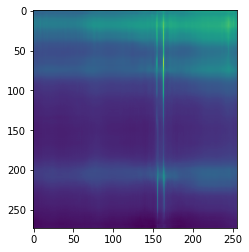

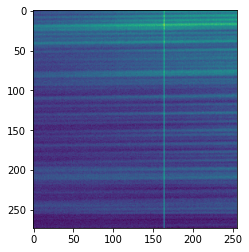

In [144]:
i=np.random.choice(np.arange(32))
plt.imshow(x_hat[i, 0, :, :].detach().numpy())
plt.show()
plt.imshow(x[i, 0, :, :].detach().numpy())
plt.show()

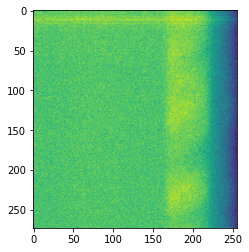

In [16]:
plt.imshow(x[0, 0, :, :].detach().numpy())

Global seed set to 1234
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type          | Params
------------------------------------------
0 | encoder | ResNetEncoder | 11.2 M
1 | decoder | ResNetDecoder | 14.9 M
2 | fc_mu   | Linear        | 525 K 
3 | fc_var  | Linear        | 525 K 
------------------------------------------
27.1 M    Trainable params
0         Non-trainable params
27.1 M    Total params
108.546   Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

In [37]:
# vae

In [32]:
from matplotlib.pyplot import imshow, figure
import numpy as np
from torchvision.utils import make_grid
from pl_bolts.transforms.dataset_normalizations import cifar10_normalization
figure(figsize=(8, 3), dpi=300)

# GET Q(z|x) PARAMETERS
# encode x to get the mu and variance parameters
x_encoded = vae.encoder(x)
mu, log_var = vae.fc_mu(x_encoded), vae.fc_var(x_encoded)

print('mu:', mu.shape)
print('log_var:', log_var.shape)

# SAMPLE Z from Q(Z|x)
std = torch.exp(log_var / 2)

# Z COMES FROM NORMAL(0, 1)
num_preds = 16
p = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(std))
z = p.rsample((num_preds,))

# SAMPLE IMAGES
with torch.no_grad():
    pred = vae.decoder(z.to(vae.device)).cpu()

# UNDO DATA NORMALIZATION
# normalize = cifar10_normalization()
# mean, std = np.array(normalize.mean), np.array(normalize.std)
img = make_grid(pred).permute(1, 2, 0).numpy()

# PLOT IMAGES
imshow(img);

NameError: name 'std' is not defined

<Figure size 2400x900 with 0 Axes>

In [28]:
from copy import deepcopy

recon_x, x, mu, log_var, z = model(images.to('cuda'))
recon_x = np.array(recon_x.cpu().detach().numpy())
x = np.array(x.cpu().detach().numpy())
xoff = images[:,1,:,:].reshape(-1, 1, 273, 256)

n=2
A = x[n][0].reshape(273, 256)
B = recon_x[n][0].reshape(273, 256)

k = int(A.shape[0]/2)
W, H = random_initialization(A,k)
W_copy = deepcopy(W)
H_copy = deepcopy(H)

W_A, H_A = SpotDIff().factor(V=A, r=k)

IndexError: index 1 is out of bounds for dimension 1 with size 1

In [ ]:
def random_initialization(A,rank):
    number_of_documents = A.shape[0]
    number_of_terms = A.shape[1]
    W = np.random.uniform(1,2,(number_of_documents,rank))
    H = np.random.uniform(1,2,(rank,number_of_terms))
    return W,H

In [ ]:
random_initialization(A, 15)[1].shape

In [100]:
class SpotDIff:
    def __init__(self, imagearr1=None, imagearr2=None, t_div=4, f_div=4, ):
        self.img1 = imagearr1
        self.img2 = imagearr2
        self.t_div = t_div
        self.f_div = f_div
    
    def make_tiles(self, imgarr, n_ftiles=4, n_ttiles=4):
        f_div = imgarr.shape[1]//n_ftiles
        t_div = imgarr.shape[0]//n_ttiles
        tiles = {}
        for t in range(0, t_div*n_ttiles, t_div):
            for f in range(0, f_div*n_ftiles, f_div):
                
                if t == imgarr.shape[0] - t_div:
                    if f == imgarr.shape[1] - f_div:
                        tiles[f'{t//t_div}_{f//f_div}'] = imgarr[t:, f: ]
                    else:
                        tiles[f'{t//t_div}_{f//f_div}'] = imgarr[t:, f: f+f_div]
                else:
                    if f == imgarr.shape[1] - f_div:
                        tiles[f'{t//t_div}_{f//f_div}'] = imgarr[t: t+t_div, f:]
                    else:
                        tiles[f'{t//t_div}_{f//f_div}'] = imgarr[t: t+t_div, f: f+f_div]                         
        
        return tiles
    
    def get_brt_pix(self, imgarr, top=0.20):
        n = int(top*imgarr.shape[0])
        brt_pix = (-imgarr).argsort()
        mask = np.zeros(imgarr.shape)
        for t in range(imgarr.shape[1]):
            brt_pix = (-imgarr[t,: ]).argsort()[:n]
            mask[t, brt_pix] = 1
        return mask
    def get_nmf_model(self, n_components=15, init='random', random_state=0, max_iter=1000):
        return NMF(n_components=n_components, init=init, random_state=random_state, max_iter=max_iter)
    
    def anamoly_score(self,recon_img=None, real_img=None):
        '''
        returns anamoly scpre per frequency per tile
        '''
        real_img_tiles = self.make_tiles(real_img)
        recon_img_tiles = self.make_tiles(recon_img*(real_img.max()/recon_img.max()))
        anamoly = {}
        for tile_no, tile_img in real_img_tiles.items():
            mask_real_img_tile = self.get_brt_pix(tile_img)
            mask_recon_img_tile = self.get_brt_pix(recon_img_tiles[tile_no])
            mask_real_img_tile[mask_real_img_tile==mask_recon_img_tile]=0
            anamoly_presence_tile = []
            for f in range(mask_real_img_tile.shape[1]):
                total_pix_count_f = mask_real_img_tile[: , f].shape[0]
                bright_pix_count_f = mask_real_img_tile[: , f].sum()
                dull_pix_count_f = total_pix_count_f - bright_pix_count_f
                r = bright_pix_count_f/dull_pix_count_f
                if r<=0.7:
                    r=0
                anamoly_presence_tile.append(r)
            max_anamoly_score_tile = max(anamoly_presence_tile)
            anamoly[tile_no] = max_anamoly_score_tile
        return anamoly
            
    

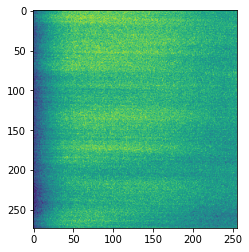

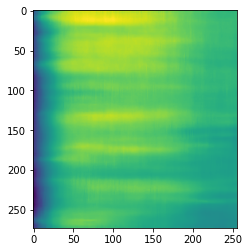

{'0_0': 0.7435897435897436,
 '0_1': 0,
 '0_2': 0,
 '0_3': 0,
 '1_0': 0.7894736842105263,
 '1_1': 0,
 '1_2': 0,
 '1_3': 0,
 '2_0': 0,
 '2_1': 0,
 '2_2': 0,
 '2_3': 0,
 '3_0': 0.7894736842105263,
 '3_1': 0,
 '3_2': 0,
 '3_3': 0}

In [175]:
for i, data in enumerate(inputs_loader):
    if i == 1:
        images = data['images']
        break
recon_x, x, mu, log_var, z = model(images.to('cuda'))
xoff = images[:,1,:,:].reshape(-1, 1, 273, 256)
recon_x = np.array(recon_x.cpu().detach().numpy())
x = np.array(x.cpu().detach().numpy())
n=np.random.choice(np.arange(32))
xon = x[n][0]
recon_xon = recon_x[n][0]
anamoly_score = SpotDIff().anamoly_score(recon_img=recon_xon, real_img=xon)
plt.imshow(xon)
plt.show()
plt.imshow(recon_xon)
plt.show()
anamoly_score


In [91]:
for i, data in enumerate(inputs_loader):
    if i == 72:
        images = data['images']
        break

In [145]:

# recon_x, x, mu, log_var, z = model(images.to('cuda'))
# xoff = images[:,1,:,:].reshape(-1, 1, 273, 256)
# recon_x = np.array(recon_x.cpu().detach().numpy())
# x = np.array(x.cpu().detach().numpy())
# print(x.shape)
# def disp_recon(n):
#     fig, a = plt.subplots(3, 1+4*2, figsize=(20,10))
#     plt.figure(figsize=(15,15))
#     for row in range(3):
#         tiles_l = ['0_0', '1_1', '2_2', '3_3']
#         if row == 0:
#                 a[row][0].imshow(recon_x[n][0])
#                 a[row][0].set_title('xon recons')
#                 tiles = SpotDIff().make_tiles(recon_x[n][0])
                
#                 i=1
#                 for tile in tiles_l:
#                     a[row][i].imshow(tiles[tile])
#                     a[row][i].set_title('original tile')
#                     brt_pix = SpotDIff().get_brt_pix(tiles[tile])
#                     a[row][i+1].imshow(brt_pix)
#                     a[row][i+1].set_title('mask tile')
#                     i +=2
#         if row == 1:
#             for col in range(1):
# #                 a[row][0].imshow(x[n][0])
# #                 a[row][0].set_title('xon')
# #                 mask = np.array(x[n][0]>0.1*np.max(x[n][0]))
# #                 a[row][1].imshow(mask)
                
#                 a[row][0].imshow(x[n][0])
#                 a[row][0].set_title('xon on')
#                 tiles = SpotDIff().make_tiles(x[n][0])
                
#                 i=1
#                 for tile in tiles_l:
#                     a[row][i].imshow(tiles[tile])
#                     a[row][i].set_title('original tile')
#                     brt_pix = SpotDIff().get_brt_pix(tiles[tile])
#                     a[row][i+1].imshow(brt_pix)
#                     a[row][i+1].set_title('mask tile')
#                     i +=2
#         if row == 2:
#             for col in range(1):
#                 a[row][col].imshow(x[n][0]-recon_x[n][0])
#                 a[row][0].set_title('xon - recon xon')
#                 tiles1 = SpotDIff().make_tiles(x[n][0])
#                 tiles2 = SpotDIff().make_tiles(recon_x[n][0]*(x[n][0].max()/recon_x[n][0].max()))
# #                 tiles=tiles1-tiles2
#                 i=1
#                 for tile in tiles_l:
# #                     a[row][i].imshow(tiles1[tile]-tiles2[tile])
# #                     a[row][i].set_title('original tile')
#                     masktile1 = SpotDIff().get_brt_pix(tiles1[tile])
#                     masktile2 = SpotDIff().get_brt_pix(tiles2[tile])
# #                     mask = masktile1
#                     masktile1[masktile1==masktile2] = 0
# #                     mask[~(masktile1==masktile2)] = 0
#                     a[row][i+1].imshow(masktile1)
#                     a[row][i+1].set_title('mask tile')
                    
#                     presence = []
#                     for f in range(masktile1.shape[1]):
#                         total_pix_count_f = masktile1[: , f].shape[0]
#                         bright_pix_count_f = masktile1[: , f].sum()
#                         dull_pix_count_f = total_pix_count_f - bright_pix_count_f
#                         r = bright_pix_count_f/dull_pix_count_f
#                         if r<=0.7:
#                             r=0
#                         presence.append(r)
# #                     clean_masktile1 = cv2.morphologyEx(masktile1, cv2.MORPH_OPEN, np.ones((2,2), np.uint8))
#                     a[row][i].plot(presence)
#                     a[row][i].set_title('.clean mask tile')
#                     i +=2
                
    
# # disp_recon(4)
# for n in range(32):
#     disp_recon(n)

In [23]:
tiles

NameError: name 'tiles' is not defined

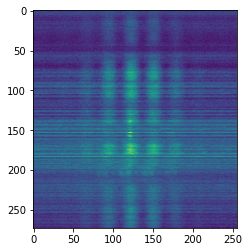

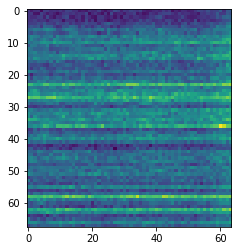

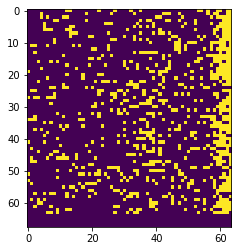

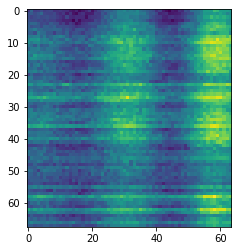

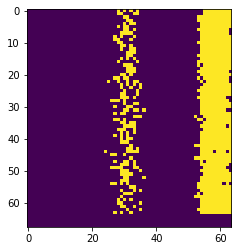

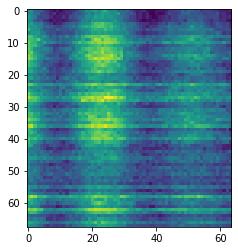

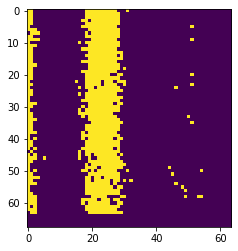

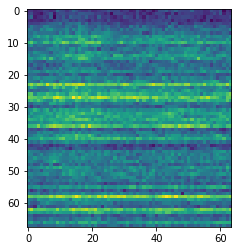

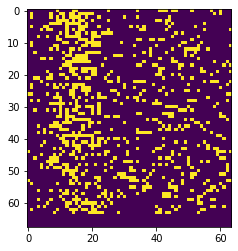

In [140]:
x=images[18,1,:,:].cpu().detach().numpy()

plt.imshow(x)
plt.show()
tiles = SpotDIff().make_tiles(x)
for f in range(4):
    plt.imshow(tiles[f'1_{f}'])
    plt.show()
    brt_pix = SpotDIff().get_brt_pix(tiles[f'1_{f}'])
    plt.imshow(brt_pix)
    plt.show()

In [128]:
68*4

272

In [38]:
tiles

{'0_0': array([[-0.4582664 , -0.30055213, -0.48438936, ..., -0.27687058,
         -0.44361803, -0.48658663],
        [-0.34938008, -0.4177392 , -0.5224752 , ..., -0.389419  ,
         -0.38526863, -0.5146627 ],
        [-0.28248578, -0.33546412, -0.3156888 , ..., -0.27003467,
         -0.42994618, -0.41969234],
        ...,
        [-0.16383387, -0.18910234, -0.2334137 , ..., -0.16041592,
         -0.2491607 , -0.25904837],
        [-0.14259371, -0.36158708, -0.42042476, ..., -0.3427883 ,
         -0.38038582, -0.34547386],
        [-0.48316866, -0.511733  , -0.4306786 , ..., -0.40211427,
         -0.4489891 , -0.40064943]], dtype=float32),
 '0_1': array([[-0.3735499 , -0.39454594, -0.35230976, ..., -0.13197362,
         -0.11860698, -0.07923944],
        [-0.38380378, -0.41456538, -0.445327  , ..., -0.38648933,
         -0.21498114, -0.17811604],
        [-0.3955225 , -0.42579582, -0.5034323 , ..., -0.05125493,
         -0.03117443, -0.28150922],
        ...,
        [-0.1507724 , -0.

In [ ]:
def scores(tileh, tilew, imgarr ):
    '''
    imgarr-t*f
    '''
    tiles = pd.DataFrame({'height': []*h*w, 'width': []*h*w})
    ''' tiles = {12:np.array([]))}'''
    f_div = imgarr.shape[1]//4
    t_div = 4
    for i in range(0, image.shape[0], t_div):
        for j in range(0, image.shape[1], f_div):
            
            if i==image.shape[0]-t_div:
                if j==image.shape[0] - f_div:
                    tiles[10*i+j] = image[i:, j:]
                else:
                    tiles[10*i+j] = image[i:, j: j+f_div]
            else:
                if j==image.shape[0] - f_div:
                    tiles[10*i+j] = image[i: i+t_div, j:]
                else:
                    tiles[10*i+j] = image[i: i+t_div, j: j+f_div]                
            
            image[(1//f_div)*image.shape[0]: (1//f_div)*image.shape[0], : (1//t_div)*image.shape[1]]
    tiles.append()

In [11]:
a=[1,2]
a.reverse()
a

[2, 1]

In [12]:
saved_model_name

'unet_legacy_seresnet18_bs32_Chl0_256273_mixupFalse_augSwapDropFlip_ups0_scdCosineAnnealingWarmRestarts_dropoutFalse_InvOrigNorm_epoch150'

In [13]:
a=[1, 2]
a.extend([3,4])
a

[1, 2, 3, 4]